In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import display, HTML
import json

### Data **Analysis** and **Visualization**


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB

First 5 rows of the dataset:
   fixed acidity  volatile aci

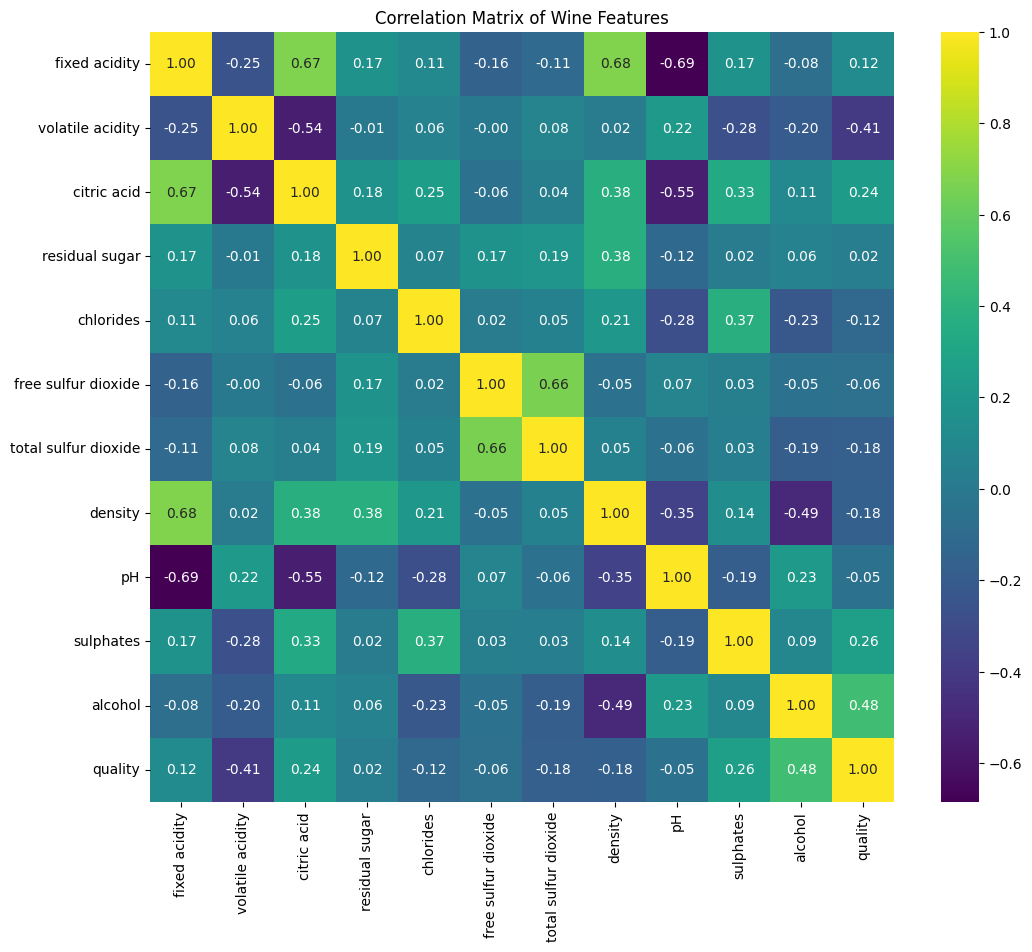

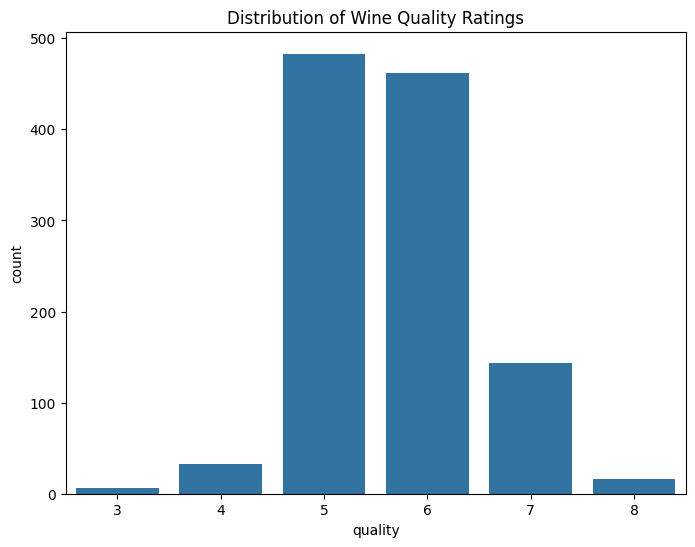

In [ ]:
df = pd.read_csv('WineQT.csv')

print("\nDataset Info:")
df.info()

print("\nFirst 5 rows of the dataset:")
print(df.head())

if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

plt.figure(figsize=(12, 10))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Wine Features')
plt.show()

print("\n")
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df)
plt.title('Distribution of Wine Quality Ratings')
plt.show()

### Data **Preprocessing**

In [ ]:
df['quality_label'] = df['quality'].apply(lambda value: 'good' if value >= 7 else 'bad')
print("\nDistribution of wine quality labels:")
print(df['quality_label'].value_counts())

X = df.drop(['quality', 'quality_label'], axis=1)
y = df['quality_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Data has been preprocessed and split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Distribution of wine quality labels:
quality_label
bad     984
good    159
Name: count, dtype: int64
Data has been preprocessed and split into training and testing sets.
Training set shape: (914, 11)
Testing set shape: (229, 11)


### Training Classifier Models

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Stochastic Gradient Descent": SGDClassifier(random_state=42),
    "Support Vector Classifier": SVC(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results[name] = accuracy

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)


--- Training Random Forest ---
Accuracy: 0.9214
Classification Report:
              precision    recall  f1-score   support

         bad       0.94      0.97      0.96       197
        good       0.79      0.59      0.68        32

    accuracy                           0.92       229
   macro avg       0.86      0.78      0.82       229
weighted avg       0.92      0.92      0.92       229


--- Training Stochastic Gradient Descent ---
Accuracy: 0.8865
Classification Report:
              precision    recall  f1-score   support

         bad       0.94      0.93      0.93       197
        good       0.59      0.62      0.61        32

    accuracy                           0.89       229
   macro avg       0.76      0.78      0.77       229
weighted avg       0.89      0.89      0.89       229


--- Training Support Vector Classifier ---
Accuracy: 0.8952
Classification Report:
              precision    recall  f1-score   support

         bad       0.91      0.98      0.94      

### Model Comparison Visualization

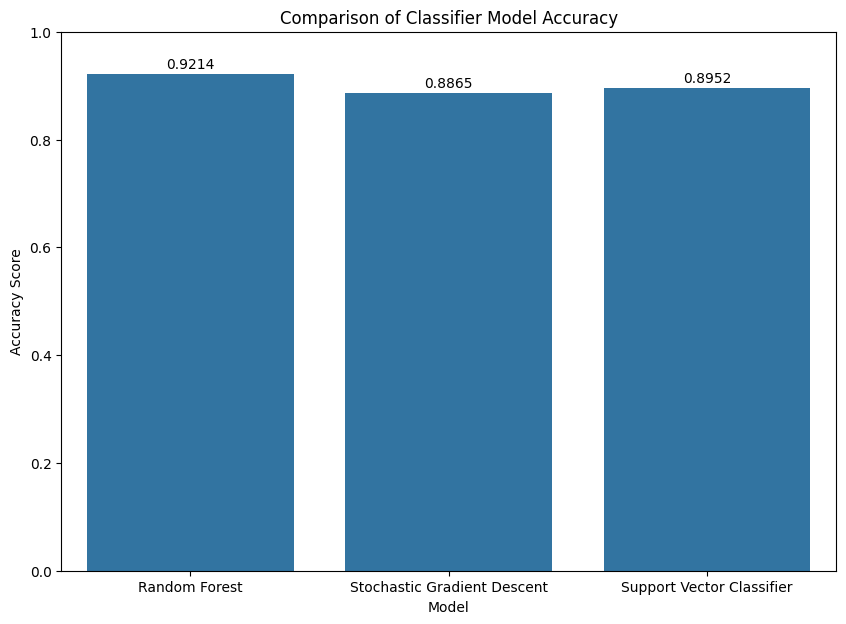

In [ ]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])

plt.figure(figsize=(10, 7))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Comparison of Classifier Model Accuracy')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1.0)

for index, row in results_df.iterrows():
    plt.text(row.name, row.Accuracy + 0.01, f"{row.Accuracy:.4f}", color='black', ha="center")

plt.show()

### Interactive Prediction Dashboard

In [ ]:
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X)

final_model = SGDClassifier(random_state=42)
final_model.fit(X_full_scaled, y)

print("Final model trained on all data.")

scaler_mean = final_scaler.mean_.tolist()
scaler_scale = final_scaler.scale_.tolist()
model_coefs = final_model.coef_[0].tolist()
model_intercept = final_model.intercept_[0]
feature_names = X.columns.tolist()

feature_stats = df.describe().loc[['min', 'max']]

html_template = """
<div style="font-family: sans-serif; padding: 20px; border: 1px solid #ccc; border-radius: 10px; background-color: #f9f9f9;">
    <h2 style="text-align: center; color: #262323;">Wine Quality Predictor</h2>
    <p style="text-align: center; color: #262323; margin-bottom: 20px;">Adjust the sliders to match the wine's chemical properties and click predict.</p>

    <div id="sliders-container" style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 15px;">
        <!-- Sliders will be dynamically generated here -->
    </div>

    <div style="text-align: center; margin-top: 25px;">
        <button id="predict-btn" style="padding: 10px 20px; font-size: 16px; border-radius: 5px; border: none; background-color: #2c3e50; color: white; cursor: pointer;">
            Predict Quality
        </button>
    </div>

    <div id="result-container" style="margin-top: 20px; text-align: center; font-size: 20px; display: none;">
        <p>Predicted Quality: <span id="prediction-output" style="font-weight: bold;"></span></p>
    </div>
</div>

<script>
    const featureNames = {feature_names};
    const scalerMean = {scaler_mean};
    const scalerScale = {scaler_scale};
    const modelCoefs = {model_coefs};
    const modelIntercept = {model_intercept};
    const featureStats = {feature_stats};

    const slidersContainer = document.getElementById('sliders-container');

    // Dynamically create a slider for each feature
    featureNames.forEach((name, i) => {{
        const min = featureStats[name]['min'];
        const max = featureStats[name]['max'];
        const avg = (min + max) / 2;
        const step = (max - min) / 100;

        const sliderDiv = document.createElement('div');
        sliderDiv.innerHTML = `
            <label for="${{name}}" style="display: block; font-size: 14px;color:#262323; margin-bottom: 5px;">${{name.replace(/_/g, ' ')}}</label>
            <input type="range" id="${{name}}" min="${{min}}" max="${{max}}" value="${{avg}}" step="${{step}}" style="width: 80%;">
            <span id="${{name}}-value">${{avg.toFixed(3)}}</span>
        `;
        slidersContainer.appendChild(sliderDiv);

        // Add event listener to update the displayed value
        document.getElementById(name).addEventListener('input', (event) => {{
            document.getElementById(`${{name}}-value`).textContent = parseFloat(event.target.value).toFixed(3);
        }});
    }});

    const predictBtn = document.getElementById('predict-btn');
    const resultContainer = document.getElementById('result-container');
    const predictionOutput = document.getElementById('prediction-output');

    predictBtn.addEventListener('click', () => {{
        // 1. Get input values from sliders
        const inputs = featureNames.map(name => parseFloat(document.getElementById(name).value));

        // 2. Scale the inputs
        const scaledInputs = inputs.map((val, i) => (val - scalerMean[i]) / scalerScale[i]);

        // 3. Calculate the decision function (dot product + intercept)
        let decisionValue = modelIntercept;
        for (let i = 0; i < scaledInputs.length; i++) {{
            decisionValue += scaledInputs[i] * modelCoefs[i];
        }}

        // 4. Determine the prediction
        const prediction = (decisionValue > 0) ? 'Good Quality' : 'Bad Quality';

        // 5. Display the result
        predictionOutput.textContent = prediction;
        predictionOutput.style.color = (prediction === 'Good Quality') ? '#27ae60' : '#c0392b';
        resultContainer.style.display = 'block';
    }});
</script>
"""

html_content = html_template.format(
    feature_names=json.dumps(feature_names),
    scaler_mean=json.dumps(scaler_mean),
    scaler_scale=json.dumps(scaler_scale),
    model_coefs=json.dumps(model_coefs),
    model_intercept=model_intercept,
    feature_stats=feature_stats.to_json()
)

display(HTML(html_content))


Final model trained on all data.
